Kaggle link: https://www.kaggle.com/c/dogs-vs-cats-redux-kernels-edition

https://wandb.ai/mlteamaau/DogsAndCats?workspace=user-qfaithencz

https://www.kaggle.com/code/eisbarinkaltenpolar/homework-4


In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/dogs-vs-cats-redux-kernels-edition/sample_submission.csv
/kaggle/input/dogs-vs-cats-redux-kernels-edition/train.zip
/kaggle/input/dogs-vs-cats-redux-kernels-edition/test.zip


## Import everything needed

In [2]:
import zipfile
import glob
from PIL import Image
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
from tqdm import tqdm
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## Unzip datasets

In [10]:
train_dir = 'train'
test_dir = 'test'
with zipfile.ZipFile('/kaggle/input/dogs-vs-cats-redux-kernels-edition/train.zip') as train_zip:
    train_zip.extractall('')
    
with zipfile.ZipFile('/kaggle/input/dogs-vs-cats-redux-kernels-edition/test.zip') as test_zip:
    test_zip.extractall('')
train_list = glob.glob(os.path.join(train_dir,'*.jpg'))
test_list = glob.glob(os.path.join(test_dir, '*.jpg'))
print(f"Train Data: {len(train_list)}")
print(f"Test Data: {len(test_list)}")

Train Data: 25000
Test Data: 12500


In [11]:
labels = [path.split('/')[-1].split('.')[0] for path in train_list]

## Plot random image with their label

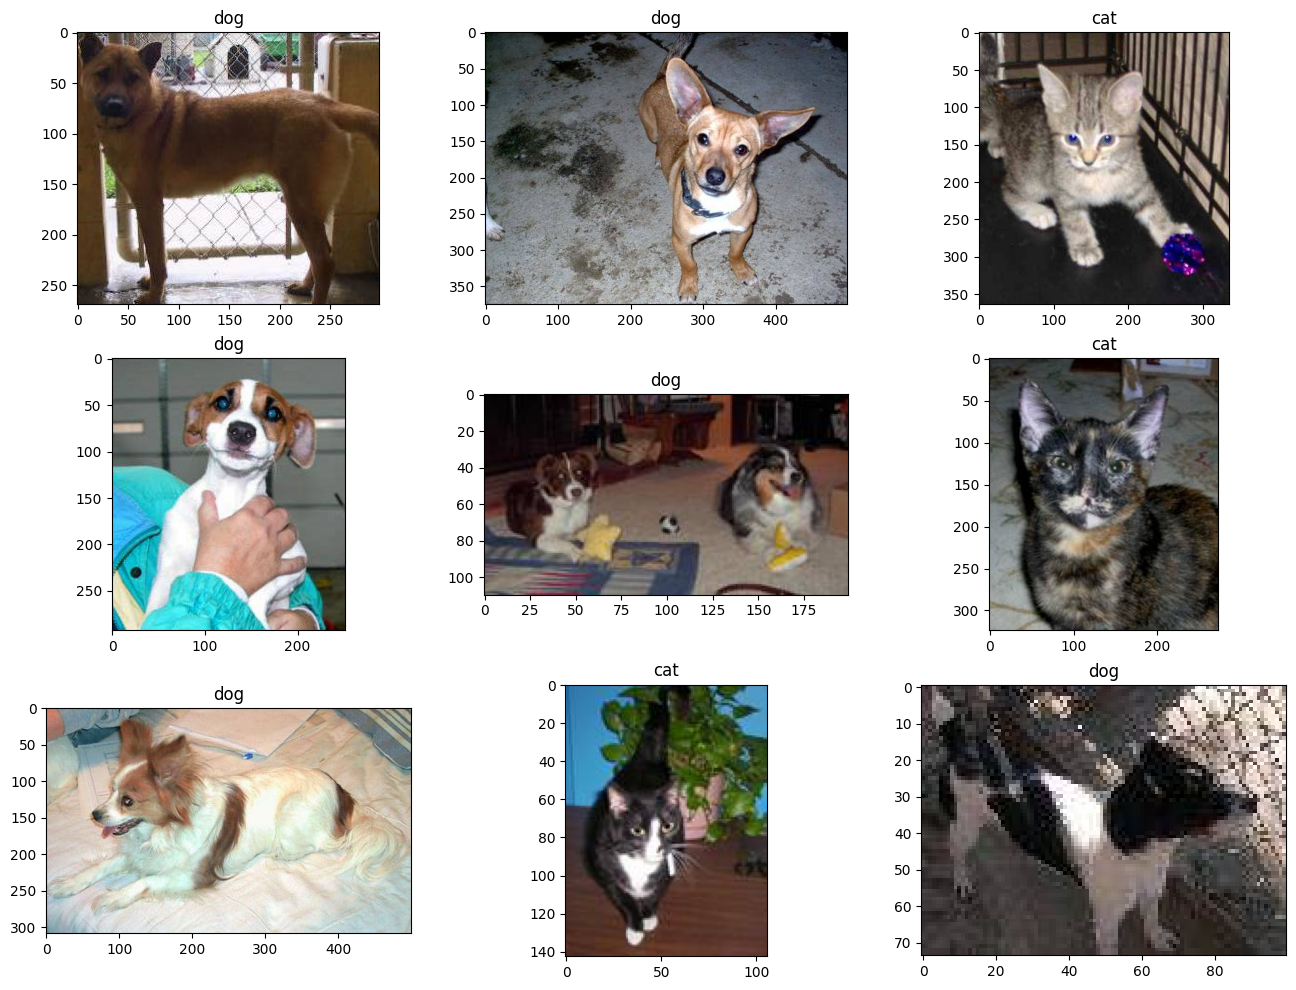

In [13]:
random_idx = np.random.randint(1, len(train_list), size=9)
fig, axes = plt.subplots(3, 3, figsize=(16, 12))

for idx, ax in enumerate(axes.ravel()):
    img = Image.open(train_list[idx])
    ax.set_title(labels[idx])
    ax.imshow(img)

## Use Sklearn to split the training data

In [14]:
train_list, valid_list = train_test_split(train_list, 
                                          test_size=0.2,
                                          stratify=labels,
                                          random_state=0)

In [15]:
print(f"Train Data: {len(train_list)}")
print(f"Validation Data: {len(valid_list)}")
print(f"Test Data: {len(test_list)}")

Train Data: 20000
Validation Data: 5000
Test Data: 12500


We will discuss this in more detail in a near future...

In [16]:
height = 258
weight = 258
RGB = 3
train_transforms = transforms.Compose([
    transforms.CenterCrop((height,weight)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

test_transforms = transforms.Compose([
    transforms.CenterCrop((height,weight)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

Define the dataset using PIL to read image

In [17]:
class CatsDogsDataset(Dataset):
    def __init__(self, file_list, transform=None):
        self.file_list = file_list
        self.transform = transform
        self.filelength = len(file_list)

    def __len__(self):
        return self.filelength

    def __getitem__(self, idx):
        img_path = self.file_list[idx]
        img = Image.open(img_path)
        
        img_transformed = self.transform(img)
        label = img_path.split("/")[-1].split(".")[0]
        label = float(1.0) if label == "dog" else float(0.0)
        return img_transformed, label

In [18]:
train_data = CatsDogsDataset(train_list, transform=train_transforms)
valid_data = CatsDogsDataset(valid_list, transform=test_transforms)
test_data = CatsDogsDataset(test_list, transform=test_transforms)

In [19]:
batch_size = 64
train_loader = DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(dataset=valid_data, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(dataset=test_data, batch_size=batch_size, shuffle=False)

Create dataloader, you can modify the batch size if needed

In [20]:
def weight_init(m):
    if isinstance(m,nn.Linear):
        nn.init.xavier_uniform_(m.weight)
        nn.init.constant_(m.bias, 0)
        return m

class Net(nn.Module):    
    def __init__(self):
        super(Net, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels = RGB, out_channels = 32, kernel_size=(3,3),padding=(2,2),stride = (1,1))
        self.pool = nn.AvgPool2d(kernel_size=(2,2),stride=(2,2))
        self.conv2 = nn.Conv2d(in_channels = 32, out_channels = 64, kernel_size=(3,3),padding=(2,2),stride = (1,1))
        self.conv3 = nn.Conv2d(in_channels = 64, out_channels = 64, kernel_size=(3,3),padding=(2,2),stride = (1,1))
        self.conv4 = nn.Conv2d(in_channels = 64, out_channels = 32, kernel_size=(3,3),padding=(2,2),stride = (1,1))
        self.conv5 = nn.Conv2d(in_channels = 32, out_channels = 16, kernel_size=(3,3),padding=(2,2),stride = (1,1))
        self.flatten = nn.Flatten()
        self.drop = nn.Dropout(0.5)
        self.ln1 = weight_init(nn.Linear(1600,800))
        self.ln2 = weight_init(nn.Linear(800,200))
        self.ln3 = weight_init(nn.Linear(200,1))
        self.sigmoid = nn.Sigmoid()
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = self.pool(self.relu(self.conv3(x)))
        x = self.pool(self.relu(self.conv4(x)))
        x = self.pool(self.relu(self.conv5(x)))
        x = self.flatten(x)
        x = self.drop(x)
        x = self.relu(self.ln1(x))
        x = self.drop(x)
        x = self.sigmoid(self.ln2(x))
        x = self.drop(x)
        x = self.sigmoid(self.ln3(x))
        return x

In [21]:
#import wandb
#wandb.init(project='DogsAndCats', save_code=True)

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [22]:
if torch.cuda.is_available():
    device =  torch.device('cuda')
else:
    device =  torch.device('cpu')    
device

device(type='cuda')

In [23]:
num_epochs = 20 # should be more than enought, but can be changed

net = Net()

net = net.to(device)
    
criterion = nn.BCELoss()
criterion = criterion.to(device)
optimizer = torch.optim.Adam(net.parameters())

for epoch in tqdm(range(num_epochs)):
    training_loss = 0
    acctrain = 0
    acc = []
    net.train()
    for images,target in train_loader:
        images = images.to(device)
        target = target.to(device)
        optimizer.zero_grad()
        predictions = net.forward(images)
        predictions = predictions.float().reshape(-1,1)
        target = target.float().reshape(-1,1)
        loss = criterion(predictions,target)
        loss.backward()
        optimizer.step()
        acc.append((torch.round(predictions) == target).float().mean().item())
        training_loss += loss.item()
        
    training_loss /= len(train_loader)
    acctrain = sum(acc)/len(acc)
    validation_loss = 0
    accvalid = 0
    acc = []
    
    net.eval()
    for images,target in valid_loader:
        images = images.to(device)
        target = target.to(device)
        with torch.no_grad():
            predictions = net.forward(images)
            predictions = predictions.float().reshape(-1,1)
            target = target.float().reshape(-1,1)
            loss = criterion(predictions,target)
            validation_loss += loss.item()
            acc.append((torch.round(predictions) == target).float().mean().item())
    
    validation_loss /= len(valid_loader)
    accvalid = sum(acc)/len(acc)

    torch.save(net.state_dict(), 'saved_model.pth')
        
    #wandb.log({'training_loss': training_loss, 'validation_loss': validation_loss, "acc train": acctrain, "acc valid": accvalid})

print("Done")

100%|██████████| 20/20 [28:27<00:00, 85.40s/it]


Done


In [70]:
with torch.no_grad():
    net.eval()
    test_pred = torch.LongTensor()
    for i, data in enumerate(test_loader):
        img,_ = data
        img = img.to(device)
        output = net(img)
        predicted = output
        predicted = predicted.cpu()
        test_pred = torch.cat((test_pred, predicted), dim=0)
    out_df = pd.DataFrame(np.c_[np.arange(1, len(test_data)+1)[:,None], test_pred.numpy()], columns=['id', 'label'])
    out_df["id"] = out_df["id"].astype(int)
    out_df.to_csv('submision.csv', index=False)